# Evaluation, Prediction & Visualization for the Best Model

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import numpy as np
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import TALOS_DIR
from app.preprocessing import load_dataset, load_embeddings, preprocess_data
from app.models import load_model, find_best_model_over_scan_logs

from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_confusion_matrix)


Using TensorFlow backend.


### Find the Best Model Against the Talos Scans

In [2]:

# TF-IDF configuration filepath 
TALOS_TF_LOG_FILENAME = 'talos_tf_log_.csv'
talos_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_TF_LOG_FILENAME)

TALOS_SDR_TF_LOG_FILENAME = 'talos_sdr_tf_log_.csv'
talos_sdr_tf_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_TF_LOG_FILENAME)

# Embeddings Centroids configuration filepath
TALOS_FTC_LOG_FILENAME = 'talos_ftc_log_.csv'
talos_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_FTC_LOG_FILENAME)

TALOS_SDR_FTC_LOG_FILENAME = 'talos_sdr_ftc_log_.csv'
talos_sdr_ftc_log_pathname = os.path.join(TALOS_DIR, TALOS_SDR_FTC_LOG_FILENAME)

best_model_params = find_best_model_over_scan_logs('val_f1', *[talos_tf_log_pathname,
                                                               talos_ftc_log_pathname,
                                                               talos_sdr_tf_log_pathname,
                                                               talos_sdr_ftc_log_pathname])


    Check the model type and load the relevant processed data

In [3]:
best_model_params



{'activation': 'relu',
 'batch_size': 32,
 'categorical_accuracy': 0.8708214285714285,
 'dropout': 0.6,
 'early_stopping': True,
 'early_stopping_config__min_delta': 0,
 'early_stopping_config__mode': 'max',
 'early_stopping_config__monitor': 'val_f1',
 'early_stopping_config__patience': 3,
 'epochs': 4,
 'f1': 0.8592413285800389,
 'first_neuron': 128,
 'loss': 0.4329330536297389,
 'model_type': 'keras_sdr_tf_idf_model',
 'number_of_hidden_layers': 0,
 'round_epochs': 4,
 'shapes': 'funnel',
 'val_categorical_accuracy': 0.8355,
 'val_f1': 0.8351940522193909,
 'val_loss': 0.524185026884079,
 'visualize_proccess': False,
 'visualize_process': nan}

In [4]:

if best_model_params['model_type'] == 'keras_tf_idf_model':
    input_ins = 'as_tf_idf'
    standarize = False
    embeddings = None

elif best_model_params['model_type'] == 'keras_sdr_tf_idf_model':
    input_ins = 'as_tf_idf'
    standarize = True
    embeddings = None
    
elif best_model_params['model_type'] == 'keras_embeddings_centroids_model':
    input_ins = 'as_centroids'
    standarize = False
    embeddings = load_embeddings(data, 'post', minimized=False)
    
else:
    input_ins = 'as_centroids'
    standarize = True
    embeddings = load_embeddings(data, 'post', minimized=False)
    
    
data = load_dataset(load_from_pickle=True, input_ins=input_ins)
model_data = preprocess_data(data, 'tags', 'post',
                             input_ins=input_ins,
                             standarize=standarize,
                             cv_split_full=0.2,
                             cv_split_dev=0.125,
                             embeddings=embeddings)
Classes = list(data['tags'].value_counts().index)
Nclasses = len(Classes)


    Train the model with the best params

In [5]:
# Add logging of each epoch run for the generation process of the best MLP Model
best_model_params['visualize_process'] = True
model_history, model = load_model(model_data['x_train'],
                                  model_data['y_train'],
                                  model_data['x_train_dev'],
                                  model_data['y_train_dev'],
                                  best_model_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total params: 642,708
Trainable params: 642,708
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.



Epoch 00001: val_f1 improved from -inf to 0.74997, saving model to keras_sdr_tf_idf_model



Epoch 00002: val_f1 improved from 0.74997 to 0.81413, saving model to keras_sdr_tf_idf_model



Epoch 00003: val_f1 improved from 0.81413 to 0.82934, saving model to keras_sdr_tf_idf_model



Epoch 00004: val_f1 improved from 0.82934 to 0.83428, saving model to keras_sdr_tf_idf_model



 ### Visualize Model History Scores

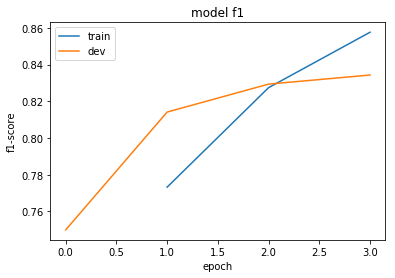

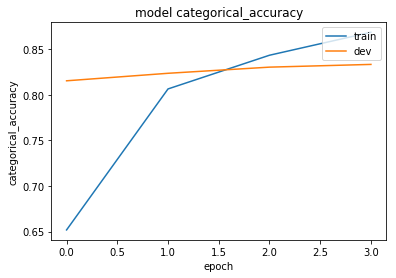

In [6]:
from app.visualization import plot_history_metrics
%matplotlib inline
plot_history_metrics(model_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [7]:
score = model.evaluate(model_data['x_test'],
                       model_data['y_test'],
                       batch_size=best_model_params['batch_size'],
                       verbose=1)

print('\nTest f1: %.4f' % (score[1]))
print('\nTest categorical accuracy: %.4f'% (score[2]))

8000/8000 [==============================] - 0s 50us/step

Test f1: 0.8218

Test categorical accuracy: 0.8201


### Visualize Prediction Perfomance of centroids MLP model

--------------------------------------------------------------------------------
Accuracy Score: 82.01%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.674     0.693     0.683       400
           1      0.938     0.902     0.920       400
           2      0.982     0.963     0.972       400
           3      0.859     0.760     0.806       400
           4      0.836     0.902     0.868       400
           5      0.608     0.718     0.658       400
           6      0.851     0.787     0.818       400
           7      0.843     0.887     0.865       400
           8      0.690     0.745     0.716       400
           9      0.668     0.685     0.677       400
          10      0.710     0.655     0.681       400
          11      0.874     0.868     0.871       400
       

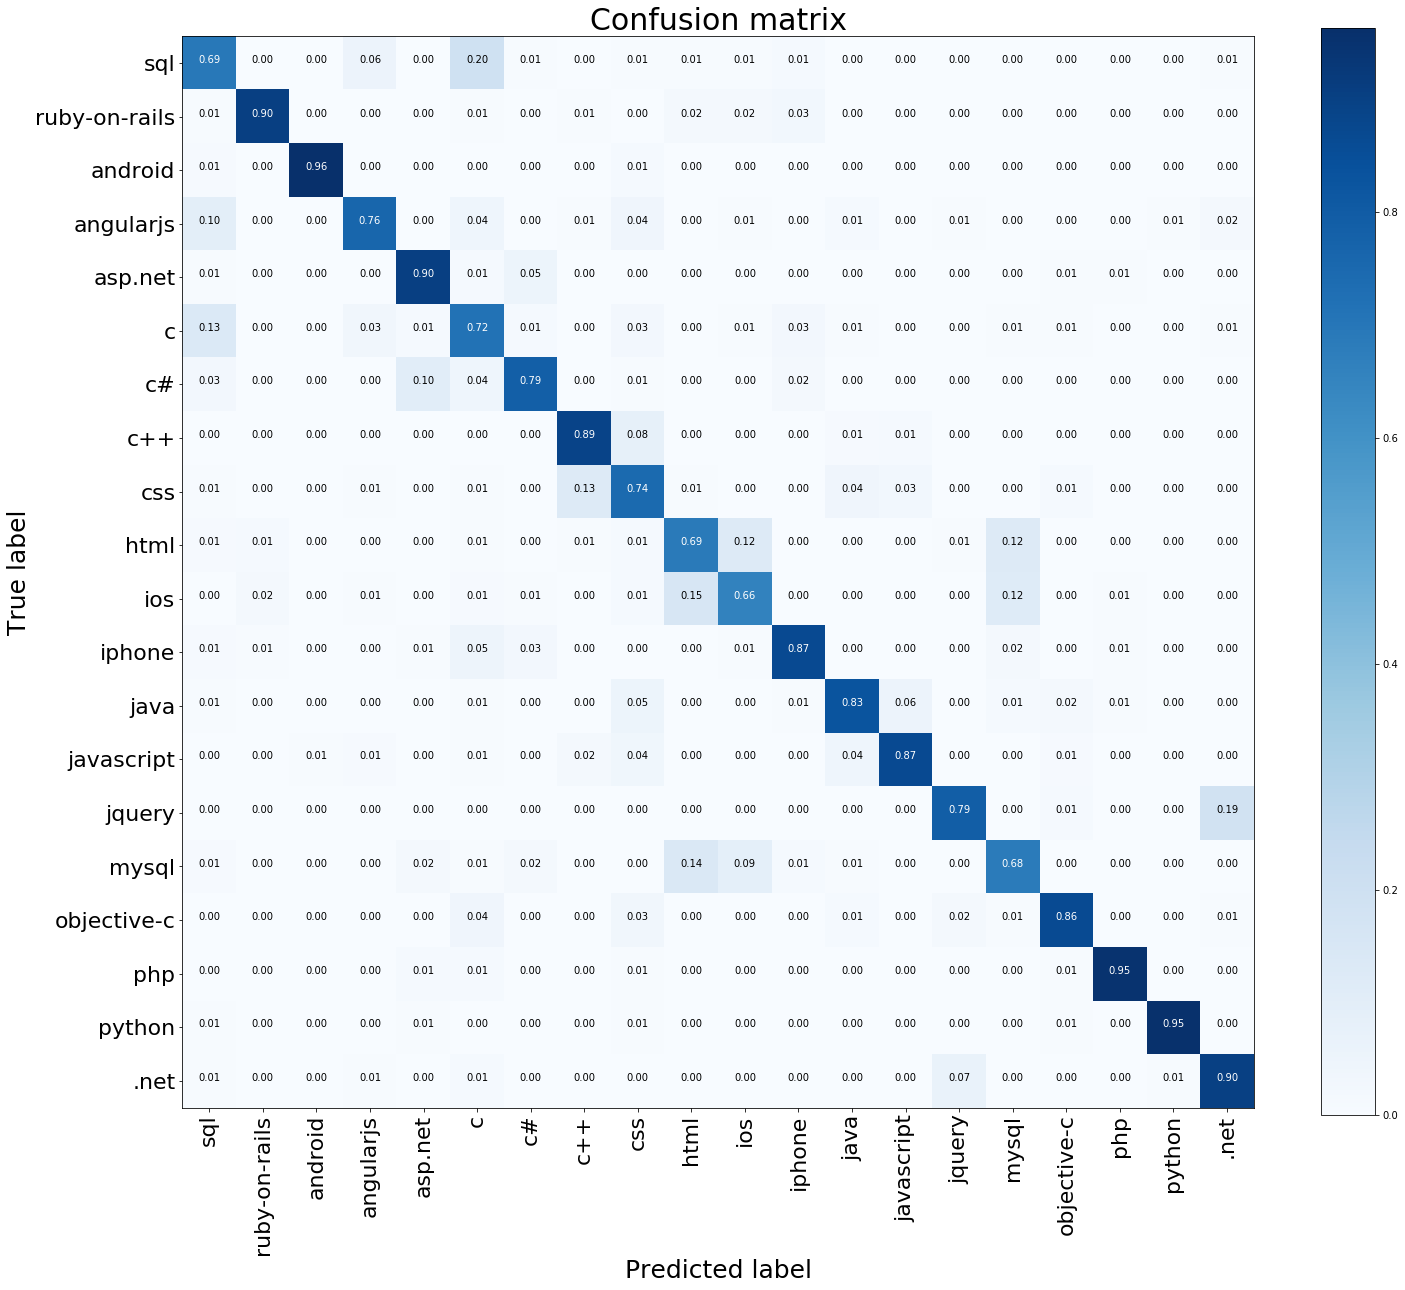

In [8]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val = model.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed = np.array([np.argmax(val) for val in prediction_val])
y_true_processed = np.array([np.argmax(val) for val in model_data['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(y_true_processed, y_pred_processed, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed, y_pred_processed, Classes)

## Comparison with simple Classifiers

In this section we want to distinguish whether a simple classifiers could have the same Performance as the tested
NN models.

In [9]:
# Transforming model data to fit for the RandomSearchCV model using SVC classifierr
text_full_train = np.vstack((model_data['x_train'],model_data['x_train_dev']))
labels_full_train = np.vstack((model_data['y_train'],model_data['y_train_dev']))
labels_full_train = np.array([np.argmax(val) for val in labels_full_train])
labels_true = np.array([np.argmax(val) for val in model_data['y_test']])

print(text_full_train.shape, labels_full_train.shape)

(32000, 5000) (32000,)


### Naive Bayer Classfier

In [10]:
##Naive Bayes classifier
#Random Grid Search with cross validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

nb_params = {
    "alpha": [0.1, 1, 10, 100],
}
nb_classifier = GridSearchCV(MultinomialNB(),
                             nb_params,
                             scoring='f1_macro',
                             cv=5,
                             n_jobs=-1,
                             verbose=10)
nb_classifier.fit(text_full_train, labels_full_train)
score_train_log=nb_classifier.best_score_


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................... alpha=0.1, score=0.745, total=   8.2s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV] ........................... alpha=0.1, score=0.747, total=   1.7s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   10.1s remaining:    0.0s


[CV] ........................... alpha=0.1, score=0.750, total=   1.0s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s


[CV] ........................... alpha=0.1, score=0.757, total=   1.0s
[CV] alpha=0.1 .......................................................


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   12.1s remaining:    0.0s


[CV] ........................... alpha=0.1, score=0.750, total=   1.0s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.2s remaining:    0.0s


[CV] ............................. alpha=1, score=0.750, total=   1.0s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   14.3s remaining:    0.0s


[CV] ............................. alpha=1, score=0.754, total=   1.0s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   15.4s remaining:    0.0s


[CV] ............................. alpha=1, score=0.757, total=   1.0s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   16.4s remaining:    0.0s


[CV] ............................. alpha=1, score=0.763, total=   1.0s
[CV] alpha=1 .........................................................


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   17.5s remaining:    0.0s


[CV] ............................. alpha=1, score=0.756, total=   1.0s
[CV] alpha=10 ........................................................
[CV] ............................ alpha=10, score=0.755, total=   1.0s
[CV] alpha=10 ........................................................
[CV] ............................ alpha=10, score=0.764, total=   1.0s
[CV] alpha=10 ........................................................
[CV] ............................ alpha=10, score=0.760, total=   0.9s
[CV] alpha=10 ........................................................
[CV] ............................ alpha=10, score=0.762, total=   0.9s
[CV] alpha=10 ........................................................
[CV] ............................ alpha=10, score=0.756, total=   1.0s
[CV] alpha=100 .......................................................
[CV] ........................... alpha=100, score=0.751, total=   1.3s
[CV] alpha=100 .......................................................
[CV] .

[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   29.1s finished


Naive Bayers  Best Params:  {'alpha': 10}
Naive Bayers Train F1 Macro Score:  0.7595
Naive Bayers Prediction F1 Macro Score is 0.752564294549545
Naive Bayer Prediction Accuracy Score is 0.754
--------------------------------------------------------------------------------
Accuracy Score: 75.40%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.604     0.583     0.593       400
           1      0.964     0.815     0.883       400
           2      0.924     0.948     0.936       400
           3      0.775     0.723     0.748       400
           4      0.753     0.907     0.823       400
           5      0.621     0.565     0.592       400
           6      0.875     0.755     0.811       400
           7      0.632     0.925     0.751       400
           8      0.640     0.5

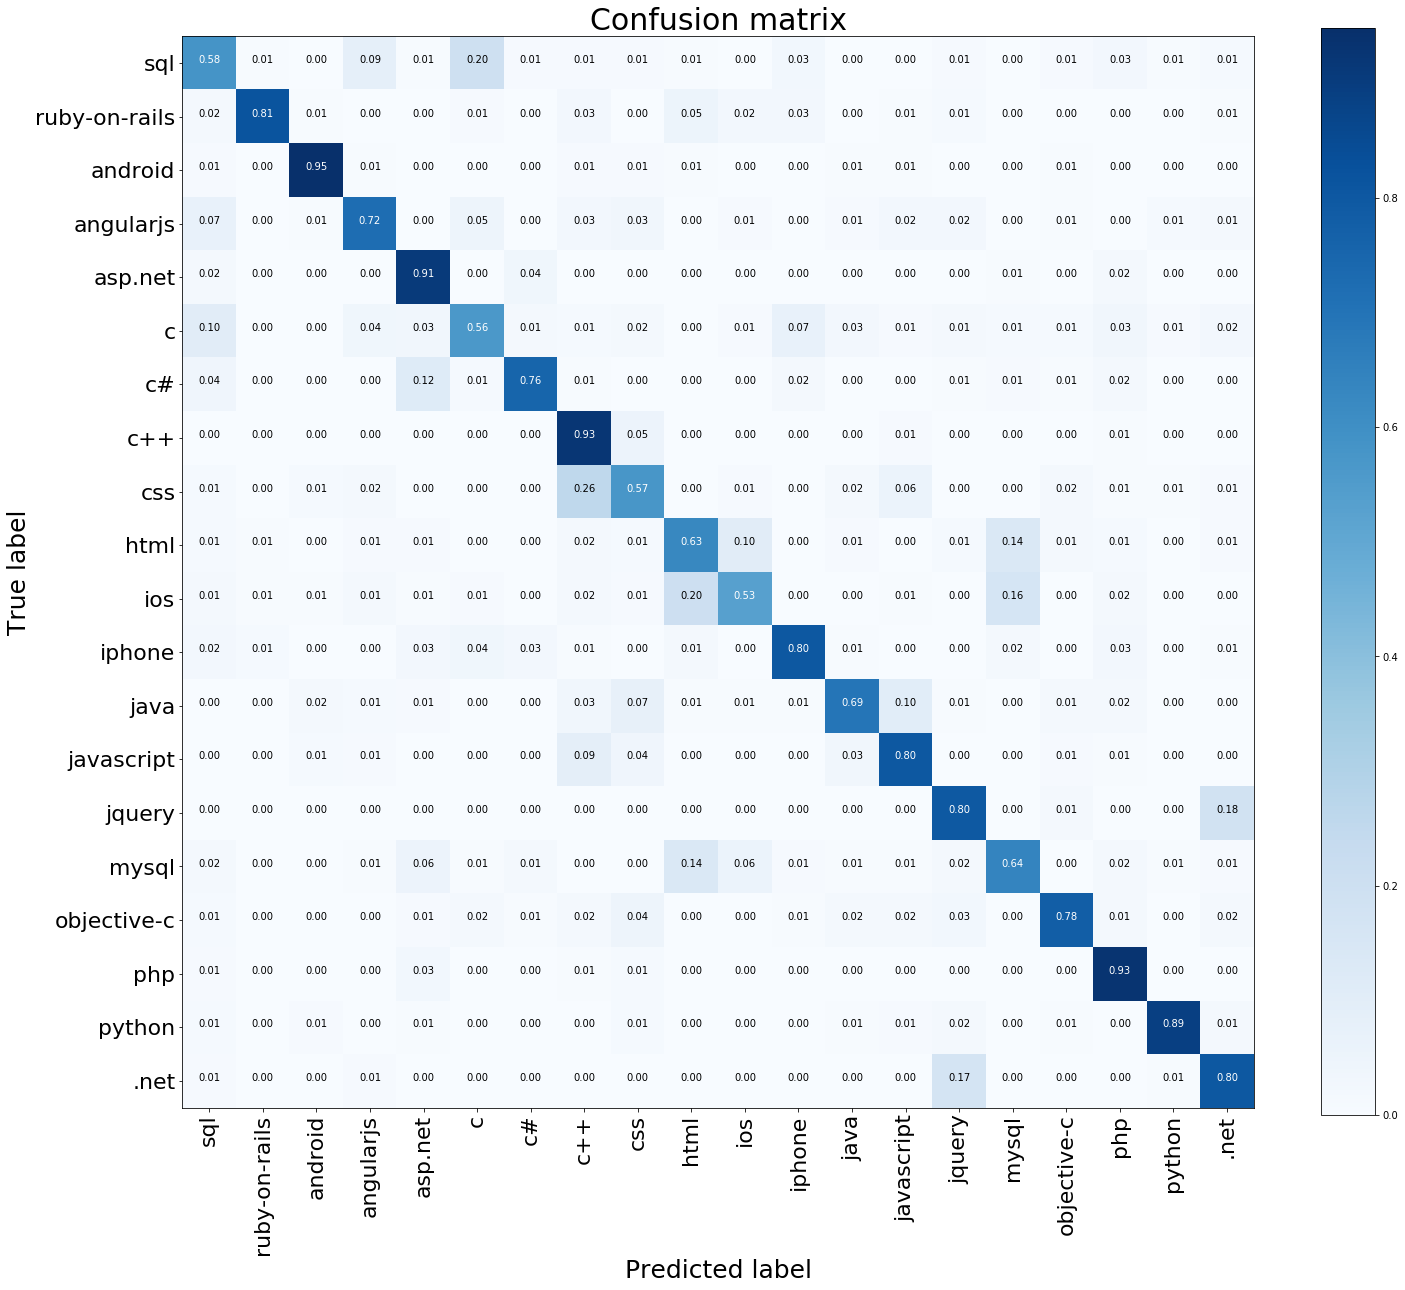

In [11]:
from sklearn.metrics import f1_score, accuracy_score

nb_labels_prediction = nb_classifier.predict(model_data['x_test'])

print("Naive Bayers  Best Params: ", nb_classifier.best_params_)
print("Naive Bayers Train F1 Macro Score: ", np.round(nb_classifier.best_score_,4))
print("Naive Bayers Prediction F1 Macro Score is {}".format(f1_score(labels_true, nb_labels_prediction, average='macro')))
print("Naive Bayer Prediction Accuracy Score is {}".format(accuracy_score(labels_true, nb_labels_prediction)))

# If you want to get the Classification Report, comment out the below line
create_clf_report(labels_true, nb_labels_prediction, Classes)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(labels_true, nb_labels_prediction, Classes)
